In [1]:
# import
import os, sys
import numpy as np
import pandas as pd
import scipy as sp

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 8})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns

sys.path.extend([r'/home/lindenmp/research_projects/snaplab_tools'])
sys.path.extend([r'/home/lindenmp/research_projects/nctpy/src'])

# import nctpy functions
from snaplab_tools.plotting.plotting import brain_scatter_plot
from snaplab_tools.plotting.utils import get_my_colors
from snaplab_tools.utils import get_schaefer_system_mask

# Load data

In [2]:
# directory where data is stored
indir = '/home/lindenmp/research_projects/nct_xr/data'
which_data = 'HCPYA'
# which_data = 'MICS'
# which_data = 'macaque'
# which_data = 'mouse'

which_fmri = 'rsts'
# which_fmri = 'taskts'
# which_fmri = 'taskts-tfMRIWMLR'
# which_fmri = 'taskts-tfMRIEMOTIONLR'

if which_fmri == 'rsts':
    outdir = '/home/lindenmp/research_projects/nct_xr/results/{0}'.format(which_data)
    # outdir = '/home/lindenmp/research_projects/nct_xr/results/int_deflections/{0}'.format(which_data)
else:
    outdir = '/home/lindenmp/research_projects/nct_xr/results/{0}/task'.format(which_data)

atlas = 'Schaefer4007'
if which_data == 'macaque':
    atlas = 'Markov'
elif which_data == 'mouse':
    atlas = 'cortex'

if atlas == 'Schaefer4007':
    n_parcels = 400
elif atlas == 'Schaefer2007':
    n_parcels = 200
elif atlas == 'Schaefer1007':
    n_parcels = 100
elif atlas == 'Markov':
    n_parcels = 182
elif atlas == 'cortex':
    n_parcels = 43

In [3]:
# extract cluster centers. These represent dominant patterns of recurrent activity over time
if which_data == 'macaque':
    parc_centroids = pd.read_csv(os.path.join(indir, 'macaque', 'MarkovCC12_M132_182-area.32k_fs_LR_mean_vertex.csv'), index_col=0)
else:
    parc_centroids = pd.read_csv(os.path.join(indir, 'Schaefer2018_{0}Parcels_7Networks_order_FSLMNI152_1mm.Centroid_RAS.csv'.format(n_parcels)), index_col=1)
    parc_centroids.drop(columns=['ROI Label'], inplace=True)
parc_centroids.head()

,R,A,S
ROI Name,,,
7Networks_LH_Vis_1,-33,-42,-21
7Networks_LH_Vis_2,-30,-33,-18
7Networks_LH_Vis_3,-36,-62,-17
7Networks_LH_Vis_4,-24,-55,-8
7Networks_LH_Vis_5,-23,-73,-10


In [4]:
# check number of clusters
# inertia_o = np.square((fmri_concat - fmri_concat.mean(axis=0))).sum()
# alpha_k = 0.005
k_range = range(2, 20)
inertia = []
# silhouette_avg = []
for k in k_range:
    fmri_clusters_file = '{0}_{1}_{2}_fmri_clusters_k-{3}.npy'.format(which_data, atlas, which_fmri, k)
    fmri_clusters = np.load(os.path.join(outdir, fmri_clusters_file), allow_pickle=True).item()
    inertia_k = fmri_clusters['inertia']
    # scaled_inertia = (inertia_k / inertia_o) + (alpha_k * k)
    # inertia.append(scaled_inertia)
    inertia.append(inertia_k)

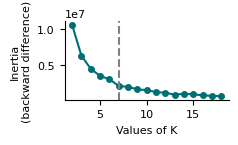

In [5]:
if which_data == 'HCPYA':
    if which_fmri == 'rsts':
        k = 7
    else:
        k = 6
        # k = 13
elif which_data == 'MICS':
    k = 5
elif which_data == 'macaque':
    k = 4

my_colors = get_my_colors()
f, ax = plt.subplots(1, 1, figsize=(2.5, 1.5))
ax.plot(k_range[:-1], np.abs(np.diff(inertia)), c=my_colors['north_sea_green'], marker='o', markersize=4)
# ax.set_xticks(k_range)
ax.set_xlabel('Values of K') 
ax.set_ylabel('Inertia\n(backward difference)')
ax.axvline(x=k, linestyle='--', c='gray')
sns.despine(ax=ax)

f.tight_layout()
plt.show()
f.savefig(os.path.join(outdir, "inertia.svg"), dpi=600, bbox_inches="tight", pad_inches=0.01)

In [6]:
# load rsfMRI clusters
fmri_clusters_file = '{0}_{1}_{2}_fmri_clusters_k-{3}.npy'.format(which_data, atlas, which_fmri, k)
fmri_clusters = np.load(os.path.join(outdir, fmri_clusters_file), allow_pickle=True).item()
print(fmri_clusters.keys())
centroids = fmri_clusters['centroids']
if which_data == 'HCPYA':
    if which_fmri == 'rsts':
        # state_swap_idx = [0, 3, 1, 2, 5, 6, 4]
        state_swap_idx = [0, 1, 2, 3, 4, 5, 6]
        centroids = centroids[state_swap_idx, :]
labels = fmri_clusters['labels']
n_states = centroids.shape[0]
n_labels = labels.shape[0]
print('n_states, {0}; n_labels, {1}'.format(n_states, n_labels))

dict_keys(['centroids', 'labels', 'inertia', 'centroid_subj_frac', 'variance_explained'])
n_states, 7; n_labels, 1152000


# Plots

### Brain states: scatter

1


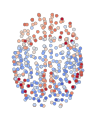

2


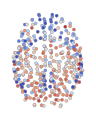

3


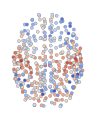

4


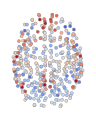

5


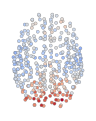

6


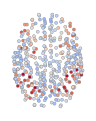

7


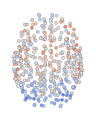

In [7]:
for state_idx in np.arange(n_states):
    print(state_idx+1)
    f = brain_scatter_plot(parcel_coords=parc_centroids, node_data=centroids[state_idx, :], vmin=-.8, vmax=.8, cmap='coolwarm', add_colorbar=False) # 
    # f = brain_scatter_plot(parcel_coords=parc_centroids, node_data=centroids[state_idx, :], cmap='coolwarm', add_colorbar=True)
    f.savefig(os.path.join(outdir, "k-{0}_cluster_{1}.svg".format(n_states, state_idx)), dpi=600, bbox_inches="tight", pad_inches=0.01)

### Brain states: correlations between states

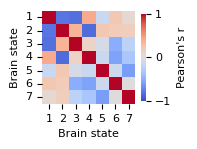

In [8]:
brain_state_corr = np.zeros((n_states, n_states))
for state_i in np.arange(n_states):
    for state_j in np.arange(n_states):
        nan_mask = np.logical_or(np.isnan(centroids[state_i, :]), np.isnan(centroids[state_j, :]))
        brain_state_corr[state_i, state_j] = sp.stats.pearsonr(centroids[state_i, ~nan_mask], centroids[state_j, ~nan_mask])[0]
        
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

sns.heatmap(brain_state_corr, square=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, cbar_kws={'shrink': 0.75, 'label': 'Pearson\'s r'})
ax.set_xlabel('Brain state')
ax.set_ylabel('Brain state')

x_tick_labels = []
for tick in ax.get_xticklabels():
    x_tick_labels.append(int(tick.get_text()) + 1)
ax.set_xticklabels(x_tick_labels, rotation=0)
y_tick_labels = []
for tick in ax.get_yticklabels():
    y_tick_labels.append(int(tick.get_text()) + 1)
ax.set_yticklabels(y_tick_labels, rotation=0)

f.savefig(os.path.join(outdir, "brain_state_correlation.svg".format(n_states, state_idx)), dpi=600, bbox_inches="tight", pad_inches=0.01)

### Brain states: correspondence with canonical systems

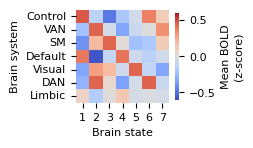

In [9]:
if which_data != 'macaque':
    yeo_systems = ['Cont', 'SalVentAttn', 'SomMot', 'Default', 'Vis', 'DorsAttn', 'Limbic'] # k = 7
    yeo_systems_labels = ['Control', 'VAN', 'SM', 'Default', 'Visual', 'DAN', 'Limbic'] # k = 7

    n_systems = len(yeo_systems)
    mean_activity = np.zeros((n_systems, n_states))
    for system_idx in np.arange(n_systems):
        system_mask = get_schaefer_system_mask(parc_centroids.index, system=yeo_systems[system_idx])
        for state_idx in np.arange(n_states):
            mean_activity[system_idx, state_idx] = np.nanmean(centroids[state_idx, system_mask])

    f, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

    sns.heatmap(mean_activity, square=True, cmap='coolwarm', center=0, vmin=-0.6, vmax=0.6, cbar_kws={'shrink': 0.75, 'label': 'Mean BOLD\n(z-score)'})
    ax.set_xlabel('Brain state')
    ax.set_ylabel('Brain system')

    x_tick_labels = []
    for tick in ax.get_xticklabels():
        x_tick_labels.append(int(tick.get_text()) + 1)
    ax.set_xticklabels(x_tick_labels, rotation=0)
    ax.set_yticklabels(yeo_systems_labels, rotation=0)
    f.savefig(os.path.join(outdir, "brain_state_system_mapping.svg".format(n_states, state_idx)), dpi=600, bbox_inches="tight", pad_inches=0.01)

# Supplementary figure

In [10]:
run_cell = False

In [11]:
if run_cell is True and which_data == 'HCPYA':
    n_systems = len(yeo_systems)

    k_range = range(2, 14)
    for k in k_range:
        print(k)
        fmri_clusters_file = '{0}_{1}_rsts_fmri_clusters_k-{2}.npy'.format(which_data, atlas, k)
        fmri_clusters = np.load(os.path.join(outdir, fmri_clusters_file), allow_pickle=True).item()
        centroids = fmri_clusters['centroids']
        n_states = centroids.shape[0]

        mean_activity = np.zeros((n_systems, n_states))
        for system_idx in np.arange(n_systems):
            system_mask = get_schaefer_system_mask(parc_centroids.index, system=yeo_systems[system_idx])
            for state_idx in np.arange(n_states):
                mean_activity[system_idx, state_idx] = centroids[state_idx, system_mask].mean()
                
        # f, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))
        f, ax = plt.subplots(1, 1, figsize=(5, 1.25))

        sns.heatmap(mean_activity, square=True, cmap='coolwarm', center=0, vmin=-0.6, vmax=0.6, cbar=False)
        ax.set_xlabel('Brain state')
        ax.set_ylabel('Brain system')

        x_tick_labels = []
        for tick in ax.get_xticklabels():
            x_tick_labels.append(int(tick.get_text()) + 1)
        ax.set_xticklabels(x_tick_labels, rotation=0)
        ax.set_yticklabels(yeo_systems_labels, rotation=0)
        plt.show()
        f.savefig(os.path.join(outdir, "k-{0}_brain_state_system_mapping.svg".format(n_states)), dpi=600, bbox_inches="tight", pad_inches=0.01)